# plotting quantified data

In [1]:
import xarray as xr
import pint_xarray
from pint_xarray import unit_registry as ureg

xr.set_options(display_expand_data=False)

## load the data

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
data = ds.air
data

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## convert units into a format understood by pint

<div class="alert alert-info">
<strong>Note:</strong> this example uses the data provided by the <code>xarray.tutorial</code> functions. As such, the <code>units</code> attributes follow the CF conventions, which <code>pint</code> does not understand by default. To work around that, we are modifying the <code>units</code> attributes here, but in general it is better to use a library that adds support for the units used by the CF conventions to <code>pint</code>.
</div>

In [3]:
data.lat.attrs["units"] = "degree"
data.lon.attrs["units"] = "degree"

## quantify the data

In [4]:
quantified = data.pint.quantify()
quantified

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[K] 241.2 242.5 243.5 244.0 244.09999 ... 297.38998 297.19 296.49 296.19 295.69
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## work with the data

In [5]:
monthly_means = (
    quantified
    .pint.to("degC")
    .sel(time="2013")
    .groupby("time.month").mean()
)
monthly_means

<xarray.DataArray 'air' (month: 12, lat: 25, lon: 53)>
[°C] -28.68323 -28.486452 -28.479755 -28.668543 ... 24.353071 24.25759 24.215012
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Most operations will preserve the units but there are some which will drop them (see the [duck array integration status](https://xarray.pydata.org/en/stable/user-guide/duckarrays.html#missing-features) page). To work around that there are unit-aware versions on the `.pint` accessor. For example, to select data use `.pint.sel` instead of `.sel`:

In [6]:
monthly_means.pint.sel(
    lat=ureg.Quantity(4350, "angular_minute"),
    lon=ureg.Quantity(12000, "angular_minute"),
)

<xarray.DataArray 'air' (month: 12)>
[°C] -26.076784 -31.216885 -22.494358 ... -3.8546731 -14.511912 -21.413227
Coordinates:
    lat      float32 4.35e+03
    lon      float32 1.2e+04
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## plot

`xarray`'s plotting functions will cast the data to `numpy.ndarray`, so we need to "dequantify" first.

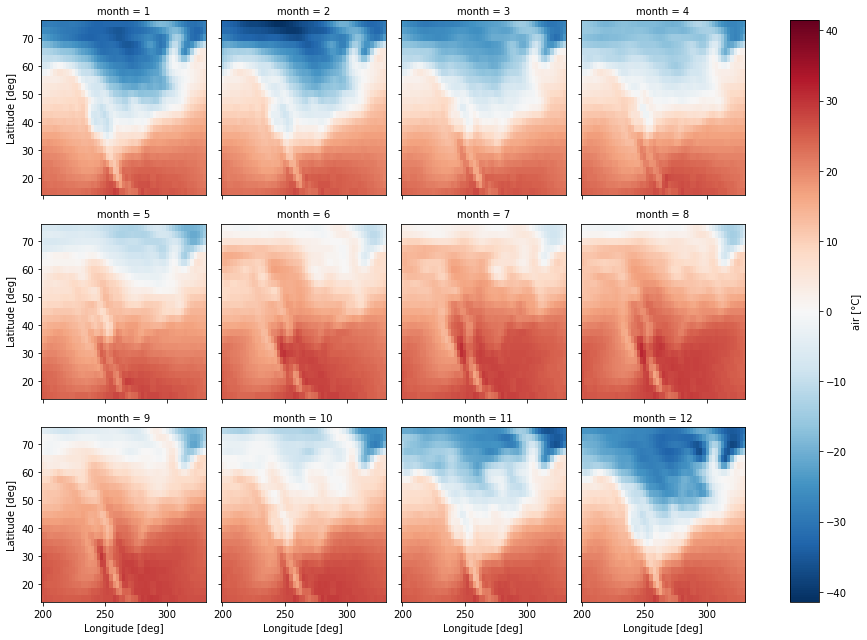

In [7]:
monthly_means.pint.dequantify(format="~P").plot.imshow(col="month", col_wrap=4)